In [1]:
from pathlib import Path
import os

import numpy as np

import torch
from torch import nn
import timm
from skimage import io, transform

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot as plt

import pandas as pd

from sklearn import metrics

from tqdm.auto import trange, tqdm

import warnings
warnings.filterwarnings("ignore")

dev = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
DATA_ROOT   = Path('./data')
WORKING_DIR = Path('./')
STUDY_PATH = WORKING_DIR / 'studies'

In [3]:
X = pd.read_csv(DATA_ROOT / 'X_train.csv')
y = pd.read_csv(DATA_ROOT / 'train_labels.csv')

In [4]:
def clean_tile(t):
    t = t.replace('\'', '_')
    return ''.join(e for e in t if e.isalnum() or e in '- _¢·v)(')

In [5]:
y['title'] = [clean_tile(x) for x in X['movie_title']]

In [6]:
[x for x in y['title'] if 'Before' in x]

['Before Sunrise',
 'The Life Before Her Eyes',
 'Before Sunset',
 'Me Before You',
 'Before I Go to Sleep',
 'Before Midnight']

In [7]:
class PostersDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, genres_csv, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.titles = [f.split('.')[0] for f in os.listdir(root_dir)]        
        self.genres = genres_csv

    def __len__(self):
        return len(self.genres)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                f'{self.titles[idx]}.jpg')
        img = io.imread(img_name)

        if self.transform:
            img = self.transform(img)

        y = self.genres[self.genres['title'] == self.titles[idx]].drop(['imdb_score', 'title'], axis=1).to_numpy()
        if len(y) == 0:
            print("============")
            print(self.titles[idx])
            print("============")
        return img, y

In [8]:
trasf = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                            ])

dataset = PostersDataset(y, DATA_ROOT / 'train_posters', transform=trasf)
train_set, val_set = \
    torch.utils.data.random_split(dataset, [int(len(dataset) * .7), int(np.ceil(len(dataset) * .3))])
                                             
train_dtld = DataLoader(train_set, batch_size=64)
test_dtld = DataLoader(val_set, batch_size=64)

In [9]:
genres = dataset.genres.drop(['imdb_score', 'title'], axis=1).columns

In [10]:
a = next(iter(train_dtld))

In [11]:
def imshow(img):
    plt.imshow(torch.movedim(img, 0, 2))

In [12]:
class ImgClass(nn.Module):
    def __init__(self):
        super(ImgClass, self).__init__()
        # self.input = nn.Conv2d(3, 3, 5, 1, 2)
        self.resnet = timm.create_model('resnet34', pretrained=True)
        self.output = nn.Linear(1000, 1)

    def forward(self, x):
        # x = self.input(x)
        x = self.resnet(x)
        return self.output(x).sigmoid()

In [13]:
models = [ImgClass().to(dev) for _ in range(19)]

In [14]:
N_EPOCHS = 10
loss_fn = nn.BCELoss()

train_losses = [[] for _ in range(19)]
train_accs = [[] for _ in range(19)]

test_losses = [[] for _ in range(19)]
test_accs = [[] for _ in range(19)]

optims = [torch.optim.Adam(models[i].parameters(), lr=1e-3) for i in range(19)]

for epoch in trange(N_EPOCHS):
    ## TRAIN
    accs = [[] for _ in range(19)]
    losses = [[] for _ in range(19)]
    for X, y in tqdm(train_dtld, leave=False):
        for i, model in enumerate(models):
            X, y = X.to(dev), y.to(dev)
            y_pred = model(X)

            loss = loss_fn(y_pred, y[:, :, i].float())
            
            acc = metrics.accuracy_score(y[:, :, i].cpu().detach().numpy(), y_pred.cpu().detach().numpy() > 0.5)

            model.zero_grad()
            loss.backward()
            optims[i].step()

            losses[i].append(loss.item())
            accs[i].append(acc)
    for acc, loss in zip(accs, losses):
        train_accs[i].append(np.mean(acc))
        train_losses[i].append(np.mean(loss))

    ## TEST
    with torch.no_grad():
        accs = [[] for _ in range(19)]
        losses = [[] for _ in range(19)]
        for X, y in tqdm(test_dtld, leave=False):
            for i, model in enumerate(models):
                X, y = X.to(dev), y.to(dev)
                y_pred = model(X)

                loss = loss_fn(y_pred, y[:, :, i].float())
                acc = metrics.accuracy_score(y[:, :, i].cpu().detach().numpy(), y_pred.cpu().detach().numpy() > 0.5)

                losses[i].append(loss.item())
                accs[i].append(acc)
                
        for i, (acc, loss) in enumerate(zip(accs, losses)):
            print(f'{genres[i]}: {np.mean(acc): .4f}, {np.mean(loss): .4f}')
            test_accs[i].append(np.mean(acc))
            test_losses[i].append(np.mean(loss))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Action:  0.7549,  0.5613
Adventure:  0.8350,  0.4563
Animation:  0.9515,  0.1789
Comedy:  0.7800,  0.4679
Crime:  0.8453,  0.4335
Documentary:  0.9891,  0.1276
Drama:  0.5590,  0.7073
Family:  0.8941,  0.3947
Fantasy:  0.9094,  0.4058
Foreign:  0.9989,  0.0636
History:  0.9610,  0.3552
Horror:  0.8818,  0.3174
Music:  0.9607,  0.3515
Mystery:  0.9333,  0.2274
Romance:  0.6164,  0.7102
Science Fiction:  0.8912,  0.3259
Thriller:  0.7605,  0.5128
War:  0.9727,  0.3422
Western:  0.9891,  0.2765


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Action:  0.7591,  0.5184
Adventure:  0.8168,  0.4221
Animation:  0.9568,  0.1337
Comedy:  0.7613,  0.5073
Crime:  0.8409,  0.4194
Documentary:  0.9891,  0.0592
Drama:  0.6365,  0.7436
Family:  0.9133,  0.2808
Fantasy:  0.9094,  0.2686
Foreign:  0.9989,  0.0666
History:  0.9610,  0.1937
Horror:  0.8845,  0.3734
Music:  0.9607,  0.1692
Mystery:  0.9333,  0.2349
Romance:  0.7448,  0.5331
Science Fiction:  0.8926,  0.2965
Thriller:  0.6635,  0.6305
War:  0.9727,  0.1254
Western:  0.9891,  0.1104


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Action:  0.7616,  0.5382
Adventure:  0.8023,  0.4754
Animation:  0.9679,  0.1022
Comedy:  0.7363,  0.8156
Crime:  0.8372,  0.4481
Documentary:  0.9891,  0.0511
Drama:  0.6532,  0.9085
Family:  0.9142,  0.2821
Fantasy:  0.8851,  0.2892
Foreign:  0.9989,  0.0666
History:  0.9610,  0.1754
Horror:  0.8282,  0.5794
Music:  0.9607,  0.1669
Mystery:  0.9289,  0.2507
Romance:  0.7142,  0.7416
Science Fiction:  0.8829,  0.3520
Thriller:  0.7048,  0.7320
War:  0.9727,  0.1688
Western:  0.9891,  0.0634


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Action:  0.7433,  0.7846
Adventure:  0.8122,  0.7111
Animation:  0.9668,  0.0966
Comedy:  0.7529,  0.8031
Crime:  0.8055,  0.6981
Documentary:  0.9891,  0.0607
Drama:  0.6292,  1.1905
Family:  0.9105,  0.4061
Fantasy:  0.8712,  0.3444
Foreign:  0.9989,  0.0655
History:  0.9610,  0.1688
Horror:  0.8832,  0.6794
Music:  0.9607,  0.1640
Mystery:  0.9286,  0.3497
Romance:  0.6543,  1.2214
Science Fiction:  0.8826,  0.5697
Thriller:  0.7471,  0.9092
War:  0.9727,  0.1196
Western:  0.9891,  0.0602


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Action:  0.7346,  0.8626
Adventure:  0.8205,  0.8250
Animation:  0.9705,  0.1197
Comedy:  0.7677,  1.0409
Crime:  0.8244,  0.6814
Documentary:  0.9891,  0.0786
Drama:  0.6359,  1.4604
Family:  0.8856,  0.4725
Fantasy:  0.8637,  0.4647
Foreign:  0.9989,  0.0663
History:  0.9610,  0.1924
Horror:  0.8486,  0.6081
Music:  0.9607,  0.1699
Mystery:  0.9333,  0.5105
Romance:  0.7563,  0.9309
Science Fiction:  0.8823,  0.4910
Thriller:  0.7213,  1.0423
War:  0.9705,  0.1732
Western:  0.9891,  0.0598


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Action:  0.7516,  0.9305
Adventure:  0.8108,  0.8659
Animation:  0.9691,  0.1155
Comedy:  0.7683,  1.6153
Crime:  0.8141,  0.9418
Documentary:  0.9880,  0.0773
Drama:  0.6810,  1.3894
Family:  0.9130,  0.5595
Fantasy:  0.8732,  0.5006
Foreign:  0.9989,  0.0664
History:  0.9599,  0.2333
Horror:  0.8681,  0.6459
Music:  0.9529,  0.2461
Mystery:  0.9230,  0.4645
Romance:  0.7869,  0.8977
Science Fiction:  0.8815,  0.6047
Thriller:  0.7559,  0.9514
War:  0.9660,  0.2342
Western:  0.9891,  0.0618


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Action:  0.7366,  1.0449
Adventure:  0.8331,  0.9499
Animation:  0.9624,  0.1811
Comedy:  0.7842,  1.0771
Crime:  0.8238,  0.9188
Documentary:  0.9891,  0.0793
Drama:  0.6892,  1.2843
Family:  0.9119,  0.5822
Fantasy:  0.8752,  0.4363
Foreign:  0.9989,  0.0657
History:  0.9610,  0.3464
Horror:  0.8625,  0.8530
Music:  0.9574,  0.2374
Mystery:  0.9124,  0.4511
Romance:  0.7965,  0.8606
Science Fiction:  0.8793,  0.5168
Thriller:  0.7466,  1.3116
War:  0.9663,  0.2064
Western:  0.9891,  0.0680


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Action:  0.7413,  1.4304
Adventure:  0.8294,  0.9950
Animation:  0.9657,  0.1479
Comedy:  0.7872,  1.0305
Crime:  0.8353,  1.1077
Documentary:  0.9891,  0.1203
Drama:  0.6440,  1.8375
Family:  0.8993,  0.6826
Fantasy:  0.8955,  0.6456
Foreign:  0.9989,  0.0670
History:  0.9532,  0.3476
Horror:  0.8670,  0.9188
Music:  0.9502,  0.3161
Mystery:  0.8912,  0.4663
Romance:  0.7682,  1.2149
Science Fiction:  0.8781,  0.6561
Thriller:  0.7606,  1.4339
War:  0.9705,  0.2908
Western:  0.9891,  0.1020


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Action:  0.7449,  1.4698
Adventure:  0.8068,  1.0548
Animation:  0.9660,  0.1452
Comedy:  0.7953,  1.5527
Crime:  0.8247,  1.2464
Documentary:  0.9891,  0.1043
Drama:  0.6605,  2.2318
Family:  0.9086,  0.6391
Fantasy:  0.9091,  0.7248
Foreign:  0.9989,  0.0665
History:  0.9599,  0.3859
Horror:  0.8737,  0.7994
Music:  0.9379,  0.3414
Mystery:  0.8960,  0.5213
Romance:  0.7766,  1.1700
Science Fiction:  0.8717,  0.7327
Thriller:  0.7154,  1.4330
War:  0.9649,  0.2985
Western:  0.9824,  0.1013


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

Action:  0.7321,  0.9985
Adventure:  0.8071,  1.2258
Animation:  0.9671,  0.1626
Comedy:  0.7800,  1.9188
Crime:  0.8177,  1.1445
Documentary:  0.9891,  0.1137
Drama:  0.6493,  2.1524
Family:  0.9027,  0.6722
Fantasy:  0.9008,  0.7558
Foreign:  0.9989,  0.0665
History:  0.9502,  0.3950
Horror:  0.8517,  0.7068
Music:  0.9267,  0.3350
Mystery:  0.8338,  0.8702
Romance:  0.7866,  1.7724
Science Fiction:  0.8737,  0.7532
Thriller:  0.7230,  1.4067
War:  0.9630,  0.2964
Western:  0.9891,  0.1062


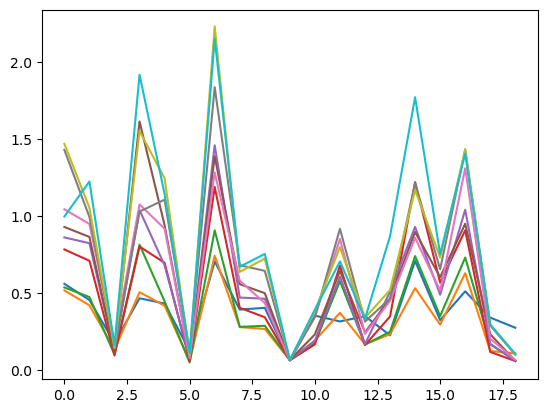

In [15]:
_ = plt.plot(test_losses)

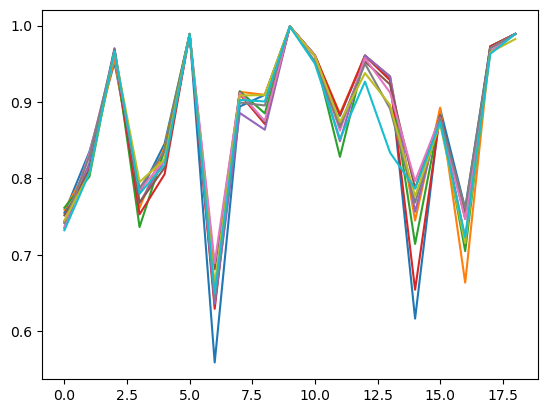

In [16]:
_ = plt.plot(test_accs)